In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),    # image파일을 0 ~ 1사이의 값을 갖는 Tensor로 변환(0: 검은색)
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), )])  # 채널별로 0.5를 빼고(-0.5 ~ 0.5), 0.5로 나눔

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000,10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset.dataset.targets[1]

9

(32, 32, 3)


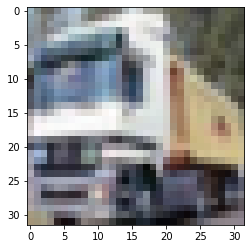

In [4]:
# img size: 32 x 32 x 3
print(trainset.dataset.data[1].shape)
plt.imshow(trainset.dataset.data[1])
plt.show()

## Define Functions

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride = 1, padding = 2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride= 2)       
        self.act = nn.ReLU()
        
        self.fc = nn.Linear(128*16*16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)  # x.size(0): batch_size dimension
        x = self.fc(x)
        return x

In [6]:
def dimension_check():
    m = CNN()
    x = torch.randn(2, 3, 32, 32)
    y = m(x)
    print(y.size())

In [7]:
dimension_check()

torch.Size([2, 10])


In [8]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True, num_workers=2)
    
    net.train()
    
    correct = 0
    total = 0
    train_loss = 0.0

    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss /= len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [9]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.val_batch_size, shuffle=False, num_workers=2)
    
    net.eval()
    
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(valloader):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        val_loss /= len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [10]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.val_batch_size, shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [11]:
def experiment(partition, args):
    m = CNN()
    m = m.cuda()
    criterion = nn.CrossEntropyLoss()
    
    if args.optim == 'SGD':
        optimizer = optim.SGD(m.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(m.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(m.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('Invalid Optimizer! Try Again')
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(1, args.epochs+1):
        ts = time.time()
        m, train_loss, train_acc = train(m, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(m, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print('Epoch: {}/{}, Acc: {:2.2f}/{:2.2f}, Loss: {:2.2f}/{:2.2f}, Took:{:2.2f}sec'.format(
                    epoch, args.epochs, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(m, partition, args)
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    return vars(args), result

## Experiments

In [12]:
import argparse

In [13]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.l2 = 0.0001
args.optim = 'Adam'
args.train_batch_size = 256
args.val_batch_size = 1024
args.lr = 0.001
args.epochs = 10

In [14]:
parameters, result = experiment(partition, args)

Epoch: 1/10, Acc: 45.87/55.19, Loss: 1.51/1.25, Took:51.22sec
Epoch: 2/10, Acc: 60.33/62.35, Loss: 1.13/1.09, Took:49.52sec
Epoch: 3/10, Acc: 65.84/64.44, Loss: 0.98/1.02, Took:50.31sec
Epoch: 4/10, Acc: 69.10/66.47, Loss: 0.89/0.98, Took:51.09sec
Epoch: 5/10, Acc: 71.62/65.66, Loss: 0.82/0.99, Took:51.52sec
Epoch: 6/10, Acc: 73.87/67.18, Loss: 0.76/0.97, Took:51.78sec
Epoch: 7/10, Acc: 75.66/66.93, Loss: 0.71/0.98, Took:50.99sec
Epoch: 8/10, Acc: 77.52/66.04, Loss: 0.66/1.02, Took:50.11sec
Epoch: 9/10, Acc: 78.70/66.63, Loss: 0.62/1.02, Took:50.71sec
Epoch: 10/10, Acc: 79.89/67.16, Loss: 0.58/1.02, Took:50.60sec


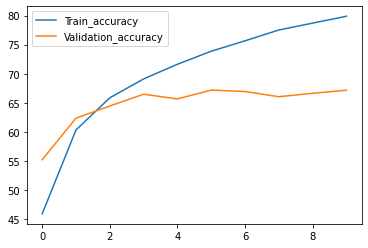

In [21]:
plt.plot(result['train_accs'], label='Train_accuracy')
plt.plot(result['val_accs'], label='Validation_accuracy')
plt.legend()
plt.show()

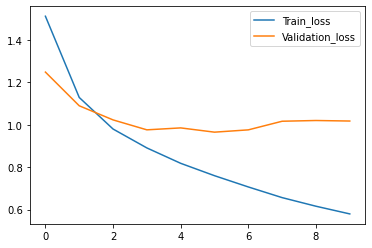

In [22]:
plt.plot(result['train_losses'], label='Train_loss')
plt.plot(result['val_losses'], label='Validation_loss')
plt.legend()
plt.show()